In [0]:
#!pip install tqdm -U

In [2]:
from tensorflow.python.client import device_lib
str(device_lib.list_local_devices()[-1]).split('\n')[-2]

'physical_device_desc: "device: XLA_CPU device"'

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Домашняя работа 
### Урок 3. TensorFlow

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.2.0-rc2


In [0]:
SEED = 1 
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### Dataset loading and preprocessing

In [0]:
(X_train , y_train) , (X_test , y_test) = keras.datasets.fashion_mnist.load_data()

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
print('',f'X_train shape: {X_train.shape}.',
         f'X_test shape: {X_test.shape}.',
         f'y_train shape: {y_train.shape}.',
         f'X_train shape: {y_test.shape}.',sep='\n')


X_train shape: (60000, 28, 28).
X_test shape: (10000, 28, 28).
y_train shape: (60000,).
X_train shape: (10000,).


In [0]:
X_train = X_train / 255.0

X_test = X_test / 255.0

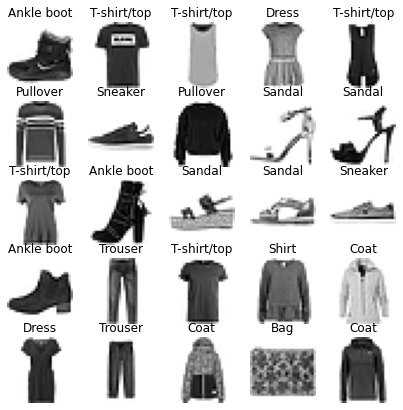

In [10]:
plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.title(class_names[y_train[i]])
plt.show()

### Model ensemble

In [0]:
def nn_graph(neurons = [128, 64, 32],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.001,
             epoch = 10,
             batch_size= 8,
             graph = True
             ):
    
    np.random.seed(SEED)
    tf.compat.v1.set_random_seed(SEED)

    
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    for i in neurons:
        model.add(keras.layers.Dense(i, activation = activation))
    model.add(keras.layers.Dense(10))
    
    model.compile(
            optimizer = optimizer(learning_rate = L_rate ),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'],
            )
    
    history = model.fit(
                        X_train, y_train,
                        epochs=epoch,
                        verbose=0,
                        validation_data = (X_test,y_test),
                        shuffle = False,
                        batch_size = batch_size,
                        )
    
    acc_train = np.round(history.history['accuracy'][-1], 4)
    acc_test = np.round(history.history['val_accuracy'][-1], 4)

    if graph:
        plt.plot(history.history['val_accuracy'],label = 'Test')
        plt.plot(history.history['accuracy'],label = 'Train')
        plt.title(f'Acc on train: {acc_train}, Accuracy on test: {acc_test}.')
        plt.legend()
        plt.show()
    else: 
        return acc_train, acc_test


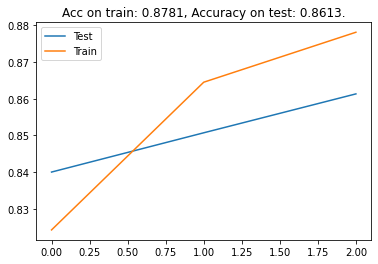

In [12]:
# test for lesson example( same parameters)
nn_graph(neurons = [128],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.001,
             epoch = 3,
             batch_size= None,
             graph = True)

Подбираем батч_сайз

In [13]:
batch_sizes = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]
batch_df = pd.DataFrame(index = batch_sizes,columns= ['train','test'])
for i in tqdm(batch_sizes):
    acc_train_, acc_test_ = nn_graph(neurons = [128],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.001,
             epoch = 5,
             batch_size= i,
             graph = False)
    batch_df.loc[i,['train','test']] = [acc_train_, acc_test_]
     

100%|██████████| 17/17 [06:03<00:00, 21.39s/it]


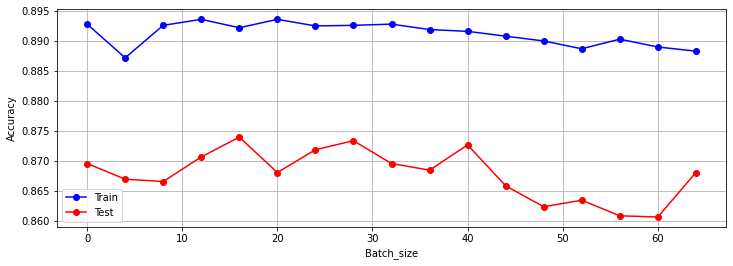

In [14]:
plt.figure(figsize=(12,4))    
plt.plot(batch_df['train'],c='blue',label='Train',marker = 'o')
plt.plot(batch_df['test'],c='red',label = 'Test',marker = 'o')
plt.grid()

plt.xlabel('Batch_size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Как видим, батч_сайз оказывает значительное влияние на качество . В процессе подбора остальных параметров можно использовать 64 для скорости(дефолтный = 32), на финальном предсказании уменьшим до 16(максимум на трейне 0.874)

Подбираем леарнинг_рэйт

In [15]:
learning_rates = np.linspace(0.0004,0.0030,14)
learning_rates_df = pd.DataFrame(index = learning_rates,columns= ['train','test'])
for i in tqdm(learning_rates):
    acc_train_, acc_test_ = nn_graph(neurons = [128],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = i,
             epoch = 5,
             batch_size= 64,
             graph = False)
    learning_rates_df.loc[i,['train','test']] = [acc_train_, acc_test_]

100%|██████████| 14/14 [02:13<00:00,  9.55s/it]


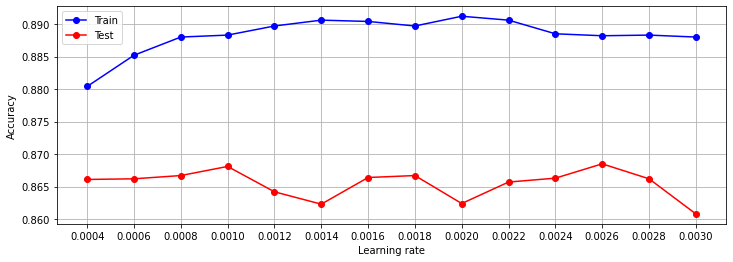

In [16]:
plt.figure(figsize=(12,4))    
plt.plot(learning_rates_df['train'],c='blue',label='Train',marker = 'o')
plt.plot(learning_rates_df['test'],c='red',label = 'Test',marker = 'o')
plt.grid()
plt.xticks(learning_rates)

plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Лернинг_рэйт можно оставить дефолтным (0.001)незначительное увеличение на 0.0026

Подбираем количество скрытых слоев и нейронов 

In [17]:
layer_1_neurons = [ 16, 32, 64, 96, 128, 192, 256, 384, 512]
layer_2_neurons = [0, 16, 32, 64, 96, 128, 192, 256, 384, 512]
grid_train_df = pd.DataFrame(index = layer_1_neurons,columns= layer_2_neurons)
grid_test_df = pd.DataFrame(index = layer_1_neurons,columns= layer_2_neurons)
for x in tqdm(layer_1_neurons):
    temp_train, temp_test = [], []
    for y in layer_2_neurons:
        if y:
            neurons = [x,y]
        else:
            neurons = [x]

        acc_train_, acc_test_ = nn_graph(neurons = neurons,
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.001,
             epoch = 5,
             batch_size= 64,
             graph = False)
        
        temp_train.append(acc_train_)
        temp_test.append(acc_test_)
    grid_train_df.loc[x,:] = temp_train 
    grid_test_df.loc[x,:] = temp_test 


100%|██████████| 9/9 [20:21<00:00, 135.72s/it]


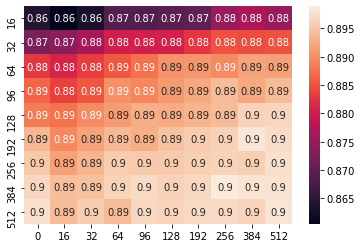

In [18]:
sns.heatmap(grid_train_df.astype('float32'), annot=True);

In [0]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

In [20]:
grid_train_df.style.apply(highlight_max)

,0,16,32,64,96,128,192,256,384,512
16,0.864200,0.860500,0.863300,0.869000,0.868700,0.869600,0.869900,0.875100,0.876900,0.875100
32,0.872600,0.874000,0.876400,0.880300,0.880500,0.880600,0.882800,0.885000,0.884500,0.885000
64,0.882900,0.880900,0.883400,0.885500,0.887400,0.890300,0.890500,0.889500,0.891700,0.891400
96,0.886400,0.883600,0.885300,0.890100,0.889200,0.891000,0.892200,0.894100,0.892300,0.894200
128,0.888300,0.887500,0.889700,0.891100,0.892800,0.892500,0.893300,0.894000,0.896400,0.896700
192,0.893600,0.889300,0.891600,0.893800,0.892800,0.894700,0.895700,0.896300,0.898300,0.897300
256,0.895400,0.891600,0.893400,0.895700,0.895500,0.895500,0.895900,0.896400,0.895900,0.897800
384,0.896900,0.894300,0.894600,0.896400,0.897100,0.896200,0.896900,0.898900,0.898100,0.897900
512,0.897700,0.894000,0.895800,0.894200,0.896800,0.896600,0.897000,0.897000,0.896500,0.898200


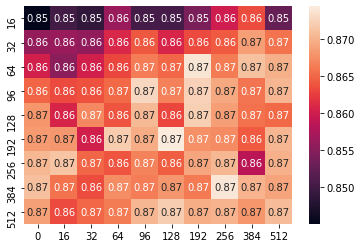

In [21]:
sns.heatmap(grid_test_df.astype('float32'), annot=True);

In [22]:
grid_test_df.style.apply(highlight_max)

,0,16,32,64,96,128,192,256,384,512
16,0.845100,0.850300,0.848900,0.856400,0.850400,0.850400,0.854200,0.860000,0.863500,0.852800
32,0.856000,0.856400,0.855800,0.861000,0.864100,0.860800,0.863400,0.864300,0.868600,0.865800
64,0.860300,0.855500,0.860300,0.863100,0.866500,0.865100,0.873900,0.866300,0.871100,0.869900
96,0.864900,0.863300,0.863800,0.865200,0.872800,0.866700,0.872400,0.869400,0.865900,0.870300
128,0.868100,0.860700,0.867100,0.863900,0.870600,0.863100,0.872200,0.868600,0.865700,0.865200
192,0.868400,0.868200,0.860300,0.871900,0.869700,0.874400,0.867700,0.867400,0.864300,0.870300
256,0.870500,0.871400,0.865000,0.863900,0.866800,0.864500,0.869200,0.870500,0.858500,0.870000
384,0.871000,0.865800,0.863500,0.867500,0.866400,0.868200,0.866200,0.874000,0.870100,0.869100
512,0.868700,0.863300,0.865100,0.866300,0.870300,0.872000,0.869800,0.870100,0.868000,0.870800


Как видим наиболее точный резльтат на тесте 0,8744 у сети [192,128] нейронов . От добавления дополнительного слоя точность на тесте выросла меньше чем на пол процента . посмотрим как поведет себя с маленьки батчем и большими эпохами 

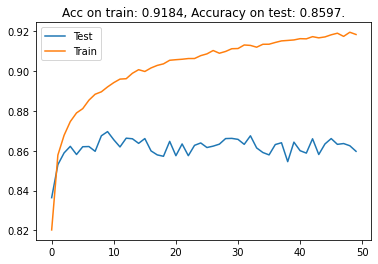

In [23]:
# Сперва протестируем сеть с одним слоем в 256 (лучший результат в таблице для
# одного слоя и кв. корень из размера трейна ):
nn_graph(neurons = [256],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.0026,
             epoch = 50,
             batch_size= 8,
             graph = True)






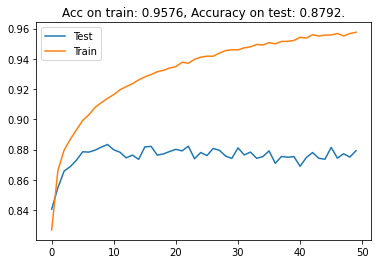

In [24]:
# Попробуем 2 слоя [192,128] (лучший результат в таблице для
# двух слоев):
nn_graph(neurons = [192, 128],
             activation = 'relu',
             optimizer = keras.optimizers.Adam,
             L_rate = 0.001,
             epoch = 50,
             batch_size= 16,
             graph = True)

На обеих моделях кривая обучения теста выходит на плато после 10 эпохи , и не растет дальше. Лучший результат на 1 слое 0.861 , на 2 слоях 0.882